In [8]:
from pathlib import Path
import sys
import numpy as np
sys.path.insert(0, str(Path.cwd().parent))
from Framework_V3.core.config import CaseConfig, GridShape
from Framework_V3.core.geometry import FinnTubedHX
from Framework_V3.models import Frostmodell_V1
from Framework_V3.runtime.simulator import Simulator
from Framework_V3.visualisation import plot
from Framework_V3.visualisation.read_from_csv import read_results_csv_json
from CoolProp.HumidAirProp import HAPropsSI

# Case Definieren

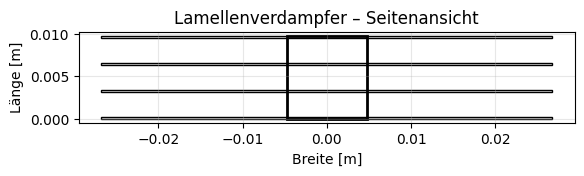

In [9]:
sim_run = True
save_data = True
read_date_from_csv = True

T_a = 2.0
T_w = -9.1
P = 103500
RH = 0.85
v_a = 1.2

cfg = CaseConfig(
    # air data
    T_a = T_a,          # °C temperature air
    v_a = v_a,          # m/s velocity air
    p_a = P,            # Pa pressure air
    RH = RH,            # relative humidity air
    w_amb = HAPropsSI('W','T',T_a+273.15,'P',P,'R', RH),          # kg/kg water vapor moisture content
    rho_amb = 1.0 / HAPropsSI("Vha","T",T_a+273.15,"P",P,"R",RH),      # kg/m^3 density air
    v_kin = 1.5e-5,     # m^2/s kinematic viscosity air
    lam = 0.025,        # W/mK heat conduction coefficient air
    c_p_a = 1000,       # J/kgK heat capacity air
    D_std = 2.2e-5,     # m^2/s water vapor diffusion coefficient
    C = 900,            # 1/s empirical water vapor absorbed coefficient
    isv = 2830000,      # J/kg latent heat of desublimation

    # refrigerant data
    T_w = T_w,          # °C wall temperature

    # ice data
    rho_i = 920,        # kg/m^3 ice density
    h_sub= 2830000,     # J/kg latent heat of ablimation for water vapor

    # numerics
    t_end = 60*10,      # s endtime
    dt = 5           # s time step
)

geom = FinnTubedHX(
    n_fin = 4,           # -
    l_fin = 0.022,          # m
    fin_thickness = 0.0002,    # m
    fin_pitch = 0.0032,          # m
    d_tube_a = 0.00952,          # m
    tube_thickness = 0.025       # m
)

gs = GridShape(
    nx = 100,
    nr = 100,
    ntheta = 90
)

plot.plot_finned_tube_side(geom)

# Simulation laufen lassen

In [10]:
if sim_run:
    sim = Simulator(fields=("t","s_e"))
    results = sim.run(cfg, geom, gs, Frostmodell_V1)

# Resultate speichen/laden

In [11]:
result_file = "results_test_edge.csv"

if save_data and sim_run:
    data = results.data
    results.to_csv(result_file,data)

if read_date_from_csv:
    data = read_results_csv_json(result_file)

# Resultate plotten

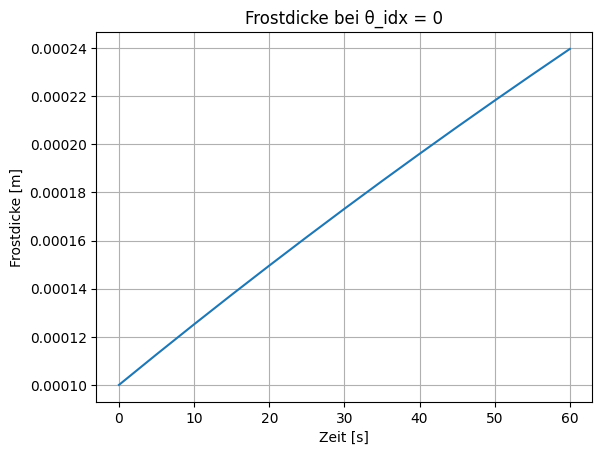

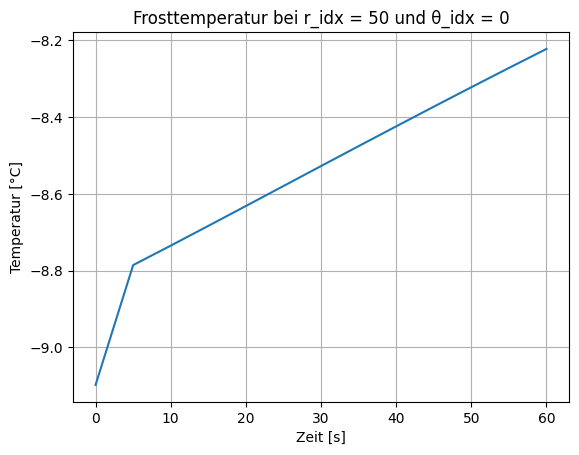

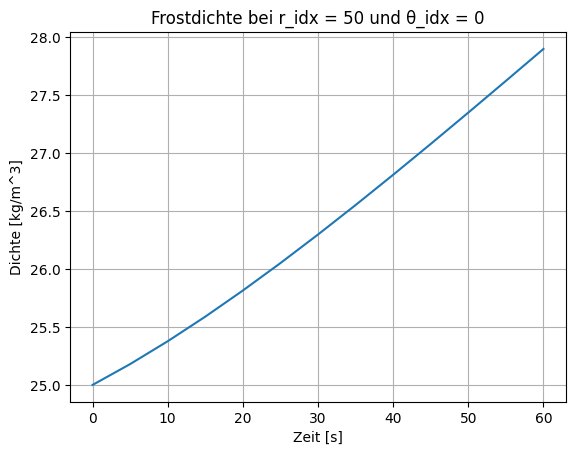

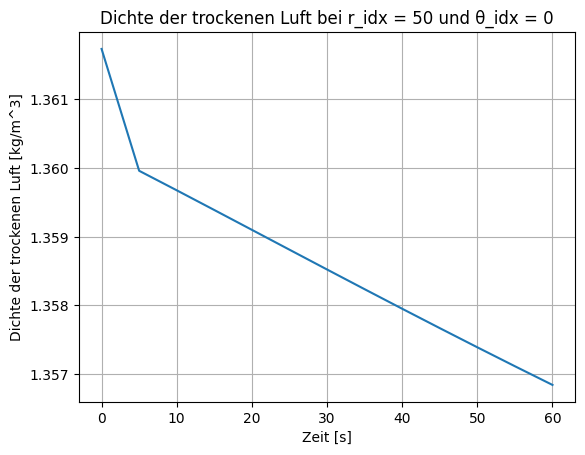

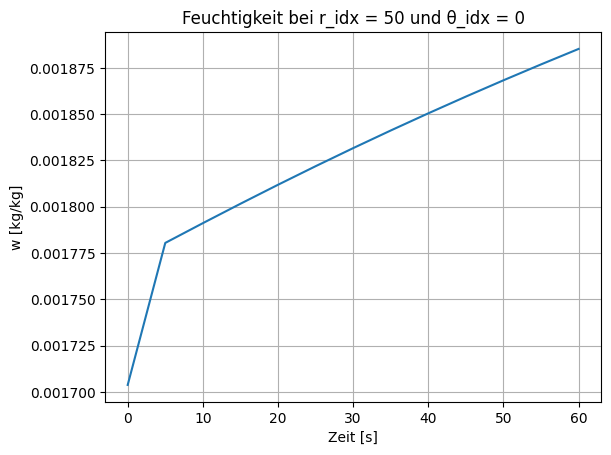

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Feuchtigkeit bei r_idx = 50 und θ_idx = 0'}, xlabel='Zeit [s]', ylabel='w [kg/kg]'>)

In [12]:
plot_r = int(gs.nr/2)
plot_theta = 0
plot_time = int(max(data['t']) / cfg.dt)

plot.plot_any(kind="time vs 1D(theta)",
              x=data['t'],y=data['s_e'],
             xlabel="Zeit [s]", ylabel="Frostdicke [m]",
             title=f"Frostdicke bei θ_idx = {plot_theta}",
             theta_idx=plot_theta, marker=None)
plot.plot_any(kind="time vs 2D(r,theta)",
              x=data['t'],y=data['T_e'],
             xlabel="Zeit [s]", ylabel="Temperatur [°C]",
             title=f"Frosttemperatur bei r_idx = {plot_r} und θ_idx = {plot_theta}",
             r_idx=plot_r, theta_idx=plot_theta, marker=None)
plot.plot_any(kind="time vs 2D(r,theta)",
              x=data['t'],y=data['rho_e'],
             xlabel="Zeit [s]", ylabel="Dichte [kg/m^3]",
             title=f"Frostdichte bei r_idx = {plot_r} und θ_idx = {plot_theta}",
             r_idx=plot_r, theta_idx=plot_theta, marker=None)
plot.plot_any(kind="time vs 2D(r,theta)",
              x=data['t'],y=data['rho_a'],
             xlabel="Zeit [s]", ylabel="Dichte der trockenen Luft [kg/m^3]",
             title=f"Dichte der trockenen Luft bei r_idx = {plot_r} und θ_idx = {plot_theta}",
             r_idx=plot_r, theta_idx=plot_theta, marker=None)
plot.plot_any(kind="time vs 2D(r,theta)",
              x=data['t'],y=data['w_e'],
             xlabel="Zeit [s]", ylabel="w [kg/kg]",
             title=f"Feuchtigkeit bei r_idx = {plot_r} und θ_idx = {plot_theta}",
             r_idx=plot_r, theta_idx=plot_theta, marker=None)

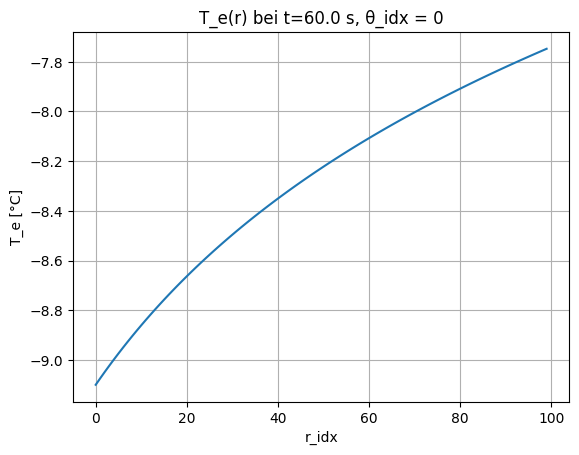

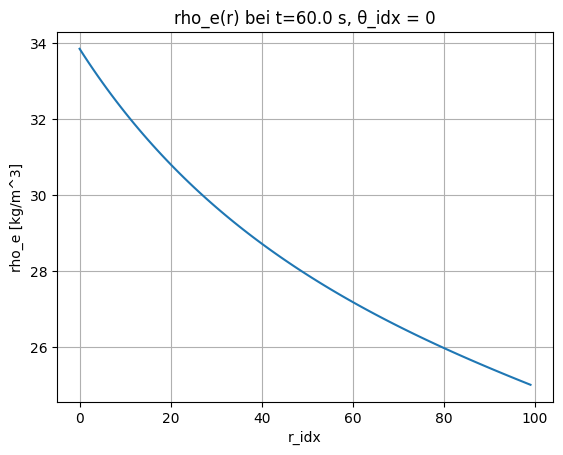

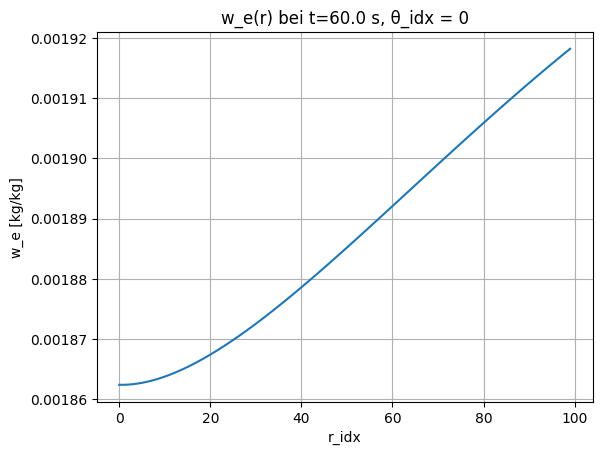

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'w_e(r) bei t=60.0 s, θ_idx = 0'}, xlabel='r_idx', ylabel='w_e [kg/kg]'>)

In [13]:
plot.plot_spatial_slice(
    data["T_e"], vary="r", t_idx=plot_time, theta_idx=plot_theta,
    title=f"T_e(r) bei t={data['t'][plot_time]} s, θ_idx = {plot_theta}", xlabel="r_idx", ylabel="T_e [°C]", marker=None
)
plot.plot_spatial_slice(
    data["rho_e"], vary="r", t_idx=plot_time, theta_idx=plot_theta,
    title=f"rho_e(r) bei t={data['t'][plot_time]} s, θ_idx = {plot_theta}", xlabel="r_idx", ylabel="rho_e [kg/m^3]", marker=None
)
plot.plot_spatial_slice(
    data["w_e"], vary="r", t_idx=plot_time, theta_idx=plot_theta,
    title=f"w_e(r) bei t={data['t'][plot_time]} s, θ_idx = {plot_theta}", xlabel="r_idx", ylabel="w_e [kg/kg]", marker=None
)

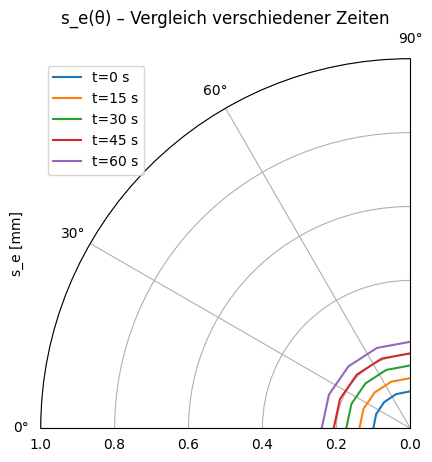

(<Figure size 640x480 with 1 Axes>,
 <PolarAxes: title={'center': 's_e(θ) – Vergleich verschiedener Zeiten'}, ylabel='s_e [mm]'>)

In [14]:
plot.plot_frost_polar_slice(
    y=data["s_e"],
    vary="theta",
    t_idx=np.linspace(0, len(data["t"]) - 1, 5, dtype=int),
    t=data.get("t", None),
    unit="mm",
    theta_max=np.pi/2,
    title="s_e(θ) – Vergleich verschiedener Zeiten"
)